### Introduction to Glove model 

##### Author - Satyam 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pylab import rcParams
import mpld3
import sys
import numpy as np 
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt 

np.random.seed(0)
sys.path.append("../../Utils/")
rcParams['figure.figsize'] = 8, 8
mpld3.enable_notebook()

In [3]:
from readWikiData import get_wikipedia_data

In [4]:
def build_co_occur_matrix(sentences, vocab_size, window_size, cc_matrix=None):
    X = np.zeros((vocab_size, vocab_size))                    
    for sentence in sentences:
        n = len(sentence)
        for i in range(n):
            wi = sentence[i] 
            
            start = max(0, i - window_size)
            end = min(n, i + window_size)
            
            if i - window_size < 0:
                points = 1.0/(1 + i)
                X[wi, 0] += points
                X[0, wi] += points
            
            if i + window_size > n:
                points = 1.0/( n - i)
                X[wi, 0] += points
                X[0, wi] += points
                
            for j in range(start, i):
                points = 1.0/(i - j)
                wj = sentence[j]
                X[wi, wj] += points
                X[wj, wi] += points
                
            for j in range(i + 1, end):
                points = 1.0/(j - i)
                wj = sentence[j]
                X[wi, wj] += points
                X[wj, wi] += points
    #np.save(X, cc_matrix)
    return X

Glove model normalize the co-occurence score of each using the following equation :- 

$$f_{i, j}(X) = \left( \frac{X_{i, j}}{X_{max}} \right)^\alpha     ,if X_{i, j} < X_{max} $$
$$= 1, otherwise $$

In [5]:
def getfX(X, xmax, alpha):
    fX = np.zeros(X.shape)
    fX[X < xmax] = (X[X<xmax]/float(xmax))**alpha
    fX[X >= xmax] = 1.0 
    return fX

The cost function in the glove model tries to learn a lower dimensional representation of the input coocurrence matrix
using the following equation :- 

$$J = \sum_{i}\sum_{j} f\left(X_{i, j}\right)\left(w_{i}^T u_{j} + b_{i} + c_{j} + mu - \log X_{i, j} \right)^2 
+ \lambda \left( {\lVert W \rVert }^2 + {\lVert u \rVert }^2 + {\lVert b \rVert }^2 + {\lVert c \rVert }^2 \right)$$

In [6]:
def normalize(X):
    return np.log(X + 1)

In [7]:
sentences, word2idx, _, _ = get_wikipedia_data(n_files=10, n_vocab=1000, by_paragraph=True)

In [8]:
X = build_co_occur_matrix(sentences=sentences, vocab_size=len(word2idx), window_size=3)

In [9]:
fX = getfX(X=X, xmax=100, alpha=0.75)

In [10]:
logX = normalize(X=X)

In [11]:
V = len(word2idx)
embedding_size = 50
learning_rate = 10e-5
epochs = 10000
reg=0.01

In [12]:
W = np.random.randn(V, embedding_size)/np.sqrt(V + embedding_size)
b = np.zeros(V)
U = np.random.randn(V, embedding_size)/np.sqrt(V + embedding_size)
c = np.zeros(V)
mu = normalize(X).mean()

Let's compute the derivates of different parameters in the cost function, w.r.t to J.

$$ \frac{\partial J}{\partial w_{i}}   = \sum_{j} f\left(X_{i, j}\right)\left(w_{i}^T u_{j} + b_{i} + c_{j} + mu - \log X_{i, j} \right)u_{j} $$

$$ \frac{\partial J}{\partial b_{i}}   = \sum_{j} f\left(X_{i, j}\right)\left(w_{i}^T u_{j} + b_{i} + c_{j} + mu - 
\log X_{i, j}\right)$$

$$ \frac{\partial J}{\partial u_{j}}   = \sum_{i} f\left(X_{i, j}\right)\left(w_{i}^T u_{j} + b_{i} + c_{j} + mu - \log X_{i, j} \right)w_{i} $$

$$ \frac{\partial J}{\partial c_{j}}   = \sum_{i} f\left(X_{i, j}\right)\left(w_{i}^T u_{j} + b_{i} + c_{j} + mu - \log X_{i, j}\right)$$

In [13]:
costs = []
for epoch in range(epochs):
    delta = W.dot(U.T) + b.reshape(1, V) + c.reshape(V, 1) + mu - logX
    cost = (fX * delta * delta).sum()
    costs.append(cost)
    
    oldW = W.copy()
    for i in range(V):
        W[i] -= learning_rate * (fX[i, :] * delta[i, :]).dot(U)
    #W -= learning_rate * reg * W
    
    for i in range(V):
        b[i] -= learning_rate*fX[i, :].dot(delta[i, :])
    #b -= learning_rate * reg * b 
    
    for j in range(V):
        U[j] -= learning_rate * (fX[:, j] * delta[:, j]).dot(oldW)
    #U -= learning_rate * reg * U
    
    for j in range(V):
        c[j] -= learning_rate * fX[:, j].dot(delta[:, j])
    #c -= learning_rate * reg * c
    
    if epoch % 1000 == 0:
        print ("epoch : ", epoch, " cost : ", cost)

epoch :  0  cost :  1164073.6096854622
epoch :  1000  cost :  88153.42251547833


KeyboardInterrupt: 

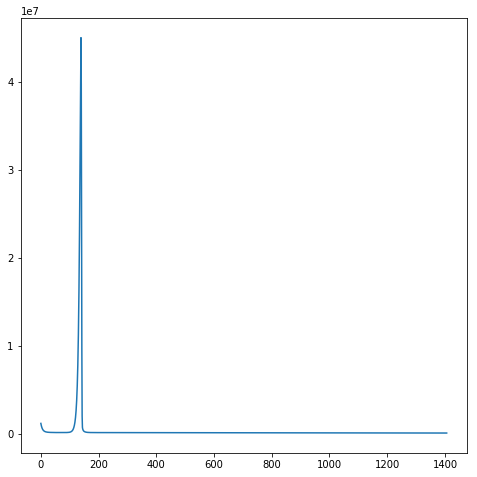

In [14]:
plt.plot(costs)
plt.show()

Plotting the trained word2vec(glove using T-SNE)

In [15]:
word2vec = np.mean([W, U], axis=0)

In [16]:
idx2word = {v:k for k, v in word2idx.items()}

In [17]:
from sklearn.manifold import TSNE
model = TSNE()
Z = model.fit_transform(word2vec) 

TypeError: array([1.]) is not JSON serializable

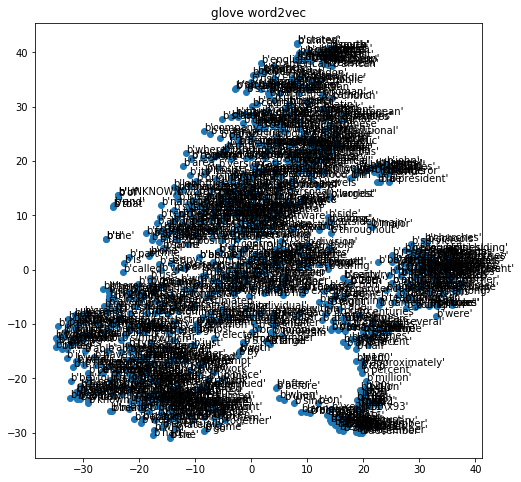

In [20]:
plt.scatter(Z[:,0], Z[:,1])
plt.title("glove word2vec")
for i in range(len(idx2word)):
    try:
        plt.annotate(s=idx2word[i].encode("utf8"), xy=(Z[i,0], Z[i,1]))
    except:
        print ("bad string:", idx2word[i])
plt.show()

Intrinsic evaluation on anological reasoning task

In [21]:
def find_analogies(w1, w2, w3, We, word2idx):
    king = We[word2idx[w1]]
    man = We[word2idx[w2]]
    woman = We[word2idx[w3]]
    v0 = king - man + woman

    def dist1(a, b):
        return np.linalg.norm(a - b)
    def dist2(a, b):
        return 1 - a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

    for dist, name in [(dist1, 'Euclidean'), (dist2, 'cosine')]:
        min_dist = float('inf')
        best_word = ''
        for word, idx in word2idx.items():
            if word not in (w1, w2, w3):
                v1 = We[idx]
                d = dist(v0, v1)
                if d < min_dist:
                    min_dist = d
                    best_word = word
        print ("closest match by", name, "distance:", best_word)
        print (w1, "-", w2, "=", best_word, "-", w3)

In [22]:
we = word2vec
w2i = word2idx

In [23]:
find_analogies(w1='1', w2='3', w3='2',We=we, word2idx=w2i)
find_analogies(w1='england', w2='london', w3='france',We=we, word2idx=w2i)
find_analogies(w1='english', w2='french', w3='german',We=we, word2idx=w2i)
find_analogies(w1='east', w2='west', w3='north',We=we, word2idx=w2i)
find_analogies(w1='lower', w2='higher', w3='low',We=we, word2idx=w2i)
find_analogies(w1='two', w2='three', w3='four',We=we, word2idx=w2i)
find_analogies(w1='december', w2='november', w3='january',We=we, word2idx=w2i)
find_analogies(w1='december', w2='november', w3='july',We=we, word2idx=w2i)
find_analogies(w1='two', w2='three', w3='five',We=we, word2idx=w2i)
find_analogies(w1='eastern', w2='western', w3='northern',We=we, word2idx=w2i)

closest match by Euclidean distance: 4
1 - 3 = 4 - 2
closest match by cosine distance: 4
1 - 3 = 4 - 2
closest match by Euclidean distance: britain
england - london = britain - france
closest match by cosine distance: britain
england - london = britain - france
closest match by Euclidean distance: chinese
english - french = chinese - german
closest match by cosine distance: chinese
english - french = chinese - german
closest match by Euclidean distance: south
east - west = south - north
closest match by cosine distance: south
east - west = south - north
closest match by Euclidean distance: surface
lower - higher = surface - low
closest match by cosine distance: surface
lower - higher = surface - low
closest match by Euclidean distance: five
two - three = five - four
closest match by cosine distance: five
two - three = five - four
closest match by Euclidean distance: october
december - november = october - january
closest match by cosine distance: october
december - november = october -

TypeError: array([1.]) is not JSON serializable

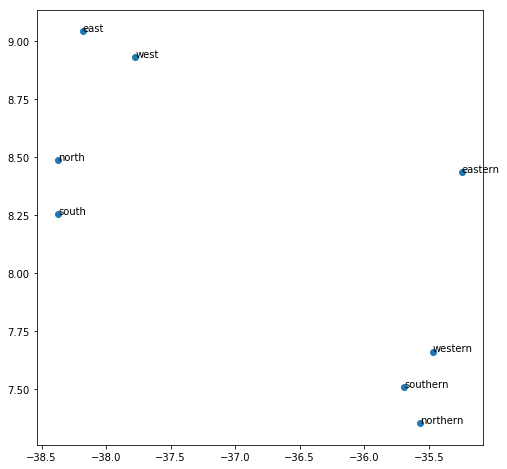

In [24]:
words = ['east', 'eastern', 'west', 'western', 'north', 'northern', 'south', 'southern']

idx = [word2idx[w] for w in words]

tsne = TSNE()
Z = tsne.fit_transform(we)
Z = Z[idx]
plt.scatter(Z[:,0], Z[:,1])
for i in range(len(words)):
    plt.annotate(s=words[i], xy=(Z[i,0], Z[i,1]))
plt.show()

TypeError: array([1.]) is not JSON serializable

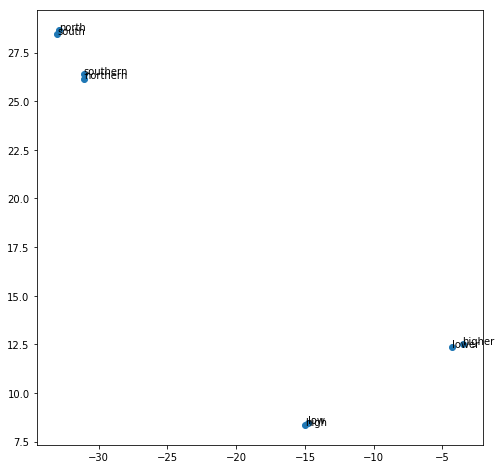

In [25]:
words = ['low', 'high', 'lower', 'higher', 'north', 'northern', 'south', 'southern']

idx = [word2idx[w] for w in words]

tsne = TSNE()
Z = tsne.fit_transform(we)
Z = Z[idx]
plt.scatter(Z[:,0], Z[:,1])
for i in range(len(words)):
    plt.annotate(s=words[i], xy=(Z[i,0], Z[i,1]))
plt.show()

#### References - 

http://www.foldl.me/2014/glove-python/